load packages

In [49]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

load data

In [50]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

Example of the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


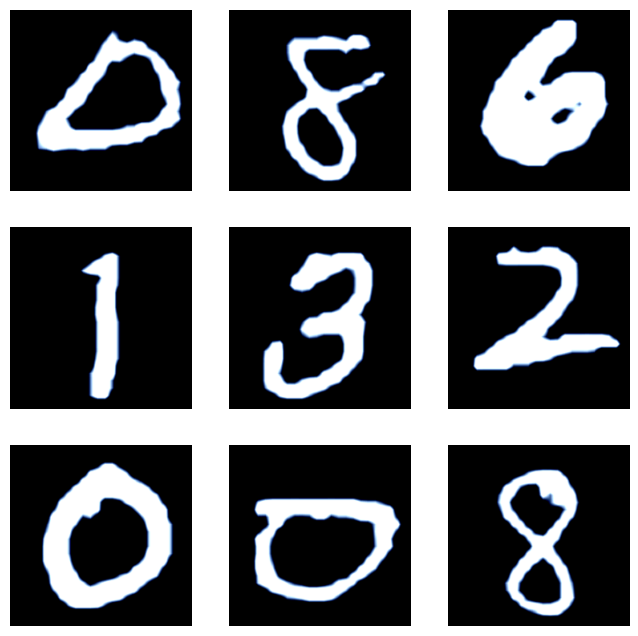

In [51]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]

    # Transpose the image to (224, 224, 3) from (3, 224, 224) for displaying with plt.imshow
    img = img.permute(1, 2, 0)

    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

Create data loaders

In [52]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size= batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size= batch_size, shuffle=True)

Create model architecture: AlexNet

In [53]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
    
        return out

num_classes = 10
model = AlexNet(num_classes).to(device)
print(model)

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
  )
  (fc1): 

Define hyperparameters

In [54]:
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

Define training function

In [55]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

define test function

In [56]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


train and evaluate the model

In [57]:
learning_rate = 0.005
loss_fn = nn.CrossEntropyLoss() #this step applies the softmax transformation and can compare the output of the model with integers
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.301744  [   64/60000]
loss: 2.303446  [ 6464/60000]
loss: 2.302653  [12864/60000]
loss: 2.298696  [19264/60000]
loss: 2.299216  [25664/60000]
loss: 2.298570  [32064/60000]
loss: 2.298641  [38464/60000]
loss: 2.292194  [44864/60000]
loss: 2.283167  [51264/60000]
loss: 2.285872  [57664/60000]
Test Error: 
 Accuracy: 46.9%, Avg loss: 2.250022 

Epoch 2
-------------------------------
loss: 2.262878  [   64/60000]
loss: 2.156526  [ 6464/60000]
loss: 1.085315  [12864/60000]
loss: 0.372158  [19264/60000]
loss: 0.388697  [25664/60000]
loss: 0.326524  [32064/60000]
loss: 0.287196  [38464/60000]
loss: 0.266248  [44864/60000]
loss: 0.134804  [51264/60000]
loss: 0.168494  [57664/60000]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.131687 

Epoch 3
-------------------------------
loss: 0.354966  [   64/60000]
loss: 0.122126  [ 6464/60000]
loss: 0.104723  [12864/60000]
loss: 0.264194  [19264/60000]
loss: 0.051203  [25664/60000]
loss: 0.072114  [32064/600

## Save model

In [59]:
import os
abs_path = r"C:\Users\tomva\OneDrive\KU Leuven\Master Theory and Research\Internship\RTNet\data\AlexNet"
torch.save(model.state_dict(), os.path.join(abs_path,'AlexNet_scratch_MNIST.pth'))